## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [ ]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_paca_pruned.pth
pquant
data
smartpixels


In [4]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

model

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
Begin prunning with MDMM pruning with Unstructured Sparsity metric function

In [5]:
from pquant import get_default_config
from IPython.display import JSON

pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [6]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [7]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [9]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )

Train ‖ Epoch 0: 100%|██████████| 196/196 [00:08<00:00, 24.06batch/s, loss=12.3773]


Loss=1.4446 | Reg=10.9328


Val   ‖ Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 37.40batch/s, acc=47.94%]


Accuracy: 47.94% | Remaining weights: 96.47% 



Train ‖ Epoch 1: 100%|██████████| 196/196 [00:07<00:00, 25.55batch/s, loss=23.6083]


Loss=1.6338 | Reg=21.9745


Val   ‖ Epoch 1: 100%|██████████| 196/196 [00:05<00:00, 37.89batch/s, acc=46.52%]


Accuracy: 46.52% | Remaining weights: 95.72% 



Train ‖ Epoch 2: 100%|██████████| 196/196 [00:07<00:00, 25.92batch/s, loss=23.8973]


Loss=1.0892 | Reg=22.8081


Val   ‖ Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 38.13batch/s, acc=58.02%]


Accuracy: 58.02% | Remaining weights: 94.27% 



Train ‖ Epoch 3: 100%|██████████| 196/196 [00:07<00:00, 25.27batch/s, loss=25.7729]


Loss=1.4191 | Reg=24.3539


Val   ‖ Epoch 3: 100%|██████████| 196/196 [00:05<00:00, 37.28batch/s, acc=47.09%]


Accuracy: 47.09% | Remaining weights: 93.09% 



Train ‖ Epoch 4: 100%|██████████| 196/196 [00:07<00:00, 25.25batch/s, loss=21.7308]


Loss=1.1449 | Reg=20.5859


Val   ‖ Epoch 4: 100%|██████████| 196/196 [00:05<00:00, 37.94batch/s, acc=62.11%]


Accuracy: 62.11% | Remaining weights: 90.59% 



Train ‖ Epoch 5: 100%|██████████| 196/196 [00:07<00:00, 25.10batch/s, loss=23.3598]


Loss=1.3947 | Reg=21.9651


Val   ‖ Epoch 5: 100%|██████████| 196/196 [00:05<00:00, 37.71batch/s, acc=32.79%]


Accuracy: 32.79% | Remaining weights: 89.45% 



Train ‖ Epoch 6: 100%|██████████| 196/196 [00:07<00:00, 24.64batch/s, loss=18.9369]


Loss=1.0513 | Reg=17.8856


Val   ‖ Epoch 6: 100%|██████████| 196/196 [00:05<00:00, 37.67batch/s, acc=63.11%]


Accuracy: 63.11% | Remaining weights: 86.23% 



Train ‖ Epoch 7: 100%|██████████| 196/196 [00:08<00:00, 24.36batch/s, loss=20.5161]


Loss=1.4461 | Reg=19.0700


Val   ‖ Epoch 7: 100%|██████████| 196/196 [00:05<00:00, 37.84batch/s, acc=41.66%]


Accuracy: 41.66% | Remaining weights: 85.29% 



Train ‖ Epoch 8: 100%|██████████| 196/196 [00:07<00:00, 24.84batch/s, loss=16.4888]


Loss=0.9126 | Reg=15.5762


Val   ‖ Epoch 8: 100%|██████████| 196/196 [00:05<00:00, 38.22batch/s, acc=65.06%]


Accuracy: 65.06% | Remaining weights: 81.50% 



Train ‖ Epoch 9: 100%|██████████| 196/196 [00:07<00:00, 24.71batch/s, loss=18.0069]


Loss=1.3131 | Reg=16.6939


Val   ‖ Epoch 9: 100%|██████████| 196/196 [00:05<00:00, 38.31batch/s, acc=45.66%]


Accuracy: 45.66% | Remaining weights: 80.77% 



Train ‖ Epoch 10: 100%|██████████| 196/196 [00:07<00:00, 25.02batch/s, loss=14.5856]


Loss=0.9198 | Reg=13.6658


Val   ‖ Epoch 10: 100%|██████████| 196/196 [00:05<00:00, 38.03batch/s, acc=63.76%]


Accuracy: 63.76% | Remaining weights: 76.61% 



Train ‖ Epoch 11: 100%|██████████| 196/196 [00:07<00:00, 25.36batch/s, loss=15.7773]


Loss=1.2031 | Reg=14.5742


Val   ‖ Epoch 11: 100%|██████████| 196/196 [00:05<00:00, 38.56batch/s, acc=38.01%]


Accuracy: 38.01% | Remaining weights: 75.95% 



Train ‖ Epoch 12: 100%|██████████| 196/196 [00:07<00:00, 25.40batch/s, loss=13.1531]


Loss=1.0850 | Reg=12.0681


Val   ‖ Epoch 12: 100%|██████████| 196/196 [00:05<00:00, 38.47batch/s, acc=63.52%]


Accuracy: 63.52% | Remaining weights: 71.74% 



Train ‖ Epoch 13: 100%|██████████| 196/196 [00:07<00:00, 25.79batch/s, loss=13.8810]


Loss=1.0718 | Reg=12.8092


Val   ‖ Epoch 13: 100%|██████████| 196/196 [00:05<00:00, 38.18batch/s, acc=47.69%]


Accuracy: 47.69% | Remaining weights: 71.18% 



Train ‖ Epoch 14: 100%|██████████| 196/196 [00:07<00:00, 25.35batch/s, loss=11.8679]


Loss=1.2313 | Reg=10.6366


Val   ‖ Epoch 14: 100%|██████████| 196/196 [00:05<00:00, 38.81batch/s, acc=64.28%]


Accuracy: 64.28% | Remaining weights: 66.97% 



Train ‖ Epoch 15: 100%|██████████| 196/196 [00:07<00:00, 25.44batch/s, loss=12.4398]


Loss=1.2508 | Reg=11.1890


Val   ‖ Epoch 15: 100%|██████████| 196/196 [00:05<00:00, 38.62batch/s, acc=34.99%]


Accuracy: 34.99% | Remaining weights: 66.45% 



Train ‖ Epoch 16: 100%|██████████| 196/196 [00:07<00:00, 25.17batch/s, loss=10.3955]


Loss=1.0073 | Reg=9.3882


Val   ‖ Epoch 16: 100%|██████████| 196/196 [00:05<00:00, 38.09batch/s, acc=64.03%]


Accuracy: 64.03% | Remaining weights: 62.45% 



Train ‖ Epoch 17: 100%|██████████| 196/196 [00:07<00:00, 25.16batch/s, loss=11.1640]


Loss=1.5261 | Reg=9.6379


Val   ‖ Epoch 17: 100%|██████████| 196/196 [00:05<00:00, 38.25batch/s, acc=45.42%]


Accuracy: 45.42% | Remaining weights: 61.75% 



Train ‖ Epoch 18: 100%|██████████| 196/196 [00:07<00:00, 25.27batch/s, loss=9.3397] 


Loss=1.0561 | Reg=8.2836


Val   ‖ Epoch 18: 100%|██████████| 196/196 [00:05<00:00, 37.99batch/s, acc=64.61%]


Accuracy: 64.61% | Remaining weights: 58.08% 



Train ‖ Epoch 19: 100%|██████████| 196/196 [00:07<00:00, 25.43batch/s, loss=9.6715]


Loss=1.2358 | Reg=8.4357


Val   ‖ Epoch 19: 100%|██████████| 196/196 [00:05<00:00, 38.08batch/s, acc=51.17%]


Accuracy: 51.17% | Remaining weights: 57.36% 



Train ‖ Epoch 20: 100%|██████████| 196/196 [00:07<00:00, 25.79batch/s, loss=8.4744]


Loss=1.1549 | Reg=7.3195


Val   ‖ Epoch 20: 100%|██████████| 196/196 [00:05<00:00, 37.97batch/s, acc=63.42%]


Accuracy: 63.42% | Remaining weights: 54.04% 



Train ‖ Epoch 21: 100%|██████████| 196/196 [00:07<00:00, 25.06batch/s, loss=8.4750]


Loss=1.2509 | Reg=7.2240


Val   ‖ Epoch 21: 100%|██████████| 196/196 [00:05<00:00, 37.48batch/s, acc=62.06%]


Accuracy: 62.06% | Remaining weights: 53.05% 



Train ‖ Epoch 22: 100%|██████████| 196/196 [00:07<00:00, 25.36batch/s, loss=7.4258]


Loss=0.9128 | Reg=6.5130


Val   ‖ Epoch 22: 100%|██████████| 196/196 [00:05<00:00, 38.57batch/s, acc=61.03%]


Accuracy: 61.03% | Remaining weights: 50.33% 



Train ‖ Epoch 23: 100%|██████████| 196/196 [00:07<00:00, 25.07batch/s, loss=7.2038]


Loss=0.9646 | Reg=6.2392


Val   ‖ Epoch 23: 100%|██████████| 196/196 [00:05<00:00, 38.48batch/s, acc=61.60%]


Accuracy: 61.60% | Remaining weights: 49.11% 



Train ‖ Epoch 24: 100%|██████████| 196/196 [00:07<00:00, 24.73batch/s, loss=6.8300]


Loss=1.0032 | Reg=5.8268


Val   ‖ Epoch 24: 100%|██████████| 196/196 [00:05<00:00, 38.58batch/s, acc=61.23%]


Accuracy: 61.23% | Remaining weights: 46.99% 



Train ‖ Epoch 25: 100%|██████████| 196/196 [00:07<00:00, 25.43batch/s, loss=6.3334]


Loss=0.9891 | Reg=5.3443


Val   ‖ Epoch 25: 100%|██████████| 196/196 [00:05<00:00, 38.86batch/s, acc=60.52%]


Accuracy: 60.52% | Remaining weights: 45.45% 



Train ‖ Epoch 26: 100%|██████████| 196/196 [00:07<00:00, 25.44batch/s, loss=6.3911]


Loss=1.2415 | Reg=5.1496


Val   ‖ Epoch 26: 100%|██████████| 196/196 [00:05<00:00, 38.53batch/s, acc=60.85%]


Accuracy: 60.85% | Remaining weights: 43.76% 



Train ‖ Epoch 27: 100%|██████████| 196/196 [00:07<00:00, 25.54batch/s, loss=5.5610]


Loss=0.9881 | Reg=4.5729


Val   ‖ Epoch 27: 100%|██████████| 196/196 [00:05<00:00, 38.57batch/s, acc=63.13%]


Accuracy: 63.13% | Remaining weights: 42.10% 



Train ‖ Epoch 28: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=5.7857]


Loss=1.2331 | Reg=4.5526


Val   ‖ Epoch 28: 100%|██████████| 196/196 [00:05<00:00, 38.42batch/s, acc=55.05%]


Accuracy: 55.05% | Remaining weights: 40.88% 



Train ‖ Epoch 29: 100%|██████████| 196/196 [00:07<00:00, 25.03batch/s, loss=4.7685]


Loss=0.8737 | Reg=3.8948


Val   ‖ Epoch 29: 100%|██████████| 196/196 [00:05<00:00, 38.09batch/s, acc=66.81%]


Accuracy: 66.81% | Remaining weights: 39.18% 



Train ‖ Epoch 30: 100%|██████████| 196/196 [00:07<00:00, 25.25batch/s, loss=4.9883]


Loss=0.9470 | Reg=4.0413


Val   ‖ Epoch 30: 100%|██████████| 196/196 [00:05<00:00, 38.70batch/s, acc=58.34%]


Accuracy: 58.34% | Remaining weights: 38.32% 



Train ‖ Epoch 31: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=4.1744]


Loss=0.7937 | Reg=3.3807


Val   ‖ Epoch 31: 100%|██████████| 196/196 [00:05<00:00, 38.12batch/s, acc=68.80%]


Accuracy: 68.80% | Remaining weights: 36.58% 



Train ‖ Epoch 32: 100%|██████████| 196/196 [00:07<00:00, 25.37batch/s, loss=4.9017]


Loss=1.1756 | Reg=3.7261


Val   ‖ Epoch 32: 100%|██████████| 196/196 [00:05<00:00, 38.97batch/s, acc=59.69%]


Accuracy: 59.69% | Remaining weights: 36.18% 



Train ‖ Epoch 33: 100%|██████████| 196/196 [00:07<00:00, 25.49batch/s, loss=3.8215]


Loss=0.8926 | Reg=2.9289


Val   ‖ Epoch 33: 100%|██████████| 196/196 [00:05<00:00, 38.39batch/s, acc=71.30%]


Accuracy: 71.30% | Remaining weights: 34.34% 



Train ‖ Epoch 34: 100%|██████████| 196/196 [00:07<00:00, 25.23batch/s, loss=4.5809]


Loss=1.1829 | Reg=3.3980


Val   ‖ Epoch 34: 100%|██████████| 196/196 [00:05<00:00, 38.48batch/s, acc=61.48%]


Accuracy: 61.48% | Remaining weights: 34.25% 



Train ‖ Epoch 35: 100%|██████████| 196/196 [00:07<00:00, 25.87batch/s, loss=3.5990]


Loss=1.0569 | Reg=2.5421


Val   ‖ Epoch 35: 100%|██████████| 196/196 [00:05<00:00, 38.79batch/s, acc=72.35%]


Accuracy: 72.35% | Remaining weights: 32.34% 



Train ‖ Epoch 36: 100%|██████████| 196/196 [00:07<00:00, 25.56batch/s, loss=4.2675]


Loss=1.1446 | Reg=3.1229


Val   ‖ Epoch 36: 100%|██████████| 196/196 [00:05<00:00, 38.41batch/s, acc=59.56%]


Accuracy: 59.56% | Remaining weights: 32.45% 



Train ‖ Epoch 37: 100%|██████████| 196/196 [00:07<00:00, 25.73batch/s, loss=3.2050]


Loss=0.9648 | Reg=2.2402


Val   ‖ Epoch 37: 100%|██████████| 196/196 [00:05<00:00, 38.42batch/s, acc=75.03%]


Accuracy: 75.03% | Remaining weights: 30.59% 



Train ‖ Epoch 38: 100%|██████████| 196/196 [00:07<00:00, 25.65batch/s, loss=4.0733]


Loss=1.2401 | Reg=2.8331


Val   ‖ Epoch 38: 100%|██████████| 196/196 [00:05<00:00, 38.36batch/s, acc=54.43%]


Accuracy: 54.43% | Remaining weights: 30.78% 



Train ‖ Epoch 39: 100%|██████████| 196/196 [00:07<00:00, 26.03batch/s, loss=2.8344]


Loss=0.8551 | Reg=1.9793


Val   ‖ Epoch 39: 100%|██████████| 196/196 [00:05<00:00, 38.73batch/s, acc=75.52%]


Accuracy: 75.52% | Remaining weights: 28.95% 



Train ‖ Epoch 40: 100%|██████████| 196/196 [00:07<00:00, 26.07batch/s, loss=3.8724]


Loss=1.2063 | Reg=2.6662


Val   ‖ Epoch 40: 100%|██████████| 196/196 [00:05<00:00, 38.56batch/s, acc=54.56%]


Accuracy: 54.56% | Remaining weights: 29.44% 



Train ‖ Epoch 41: 100%|██████████| 196/196 [00:07<00:00, 26.03batch/s, loss=2.4767]


Loss=0.6962 | Reg=1.7805


Val   ‖ Epoch 41: 100%|██████████| 196/196 [00:05<00:00, 38.35batch/s, acc=75.68%]


Accuracy: 75.68% | Remaining weights: 27.59% 



Train ‖ Epoch 42: 100%|██████████| 196/196 [00:07<00:00, 25.75batch/s, loss=3.3010]


Loss=0.8848 | Reg=2.4163


Val   ‖ Epoch 42: 100%|██████████| 196/196 [00:05<00:00, 38.68batch/s, acc=59.66%]


Accuracy: 59.66% | Remaining weights: 28.02% 



Train ‖ Epoch 43: 100%|██████████| 196/196 [00:07<00:00, 25.83batch/s, loss=2.3353]


Loss=0.7402 | Reg=1.5950


Val   ‖ Epoch 43: 100%|██████████| 196/196 [00:05<00:00, 38.58batch/s, acc=76.06%]


Accuracy: 76.06% | Remaining weights: 26.25% 



Train ‖ Epoch 44: 100%|██████████| 196/196 [00:07<00:00, 25.87batch/s, loss=3.2159]


Loss=0.9658 | Reg=2.2501


Val   ‖ Epoch 44: 100%|██████████| 196/196 [00:05<00:00, 38.71batch/s, acc=53.51%]


Accuracy: 53.51% | Remaining weights: 26.85% 



Train ‖ Epoch 45: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=2.2311]


Loss=0.7763 | Reg=1.4548


Val   ‖ Epoch 45: 100%|██████████| 196/196 [00:05<00:00, 38.41batch/s, acc=76.33%]


Accuracy: 76.33% | Remaining weights: 25.18% 



Train ‖ Epoch 46: 100%|██████████| 196/196 [00:07<00:00, 25.58batch/s, loss=3.3386]


Loss=1.1741 | Reg=2.1645


Val   ‖ Epoch 46: 100%|██████████| 196/196 [00:05<00:00, 38.29batch/s, acc=43.30%]


Accuracy: 43.30% | Remaining weights: 25.86% 



Train ‖ Epoch 47: 100%|██████████| 196/196 [00:07<00:00, 25.23batch/s, loss=2.1457]


Loss=0.8147 | Reg=1.3309


Val   ‖ Epoch 47: 100%|██████████| 196/196 [00:05<00:00, 38.02batch/s, acc=76.39%]


Accuracy: 76.39% | Remaining weights: 24.13% 



Train ‖ Epoch 48: 100%|██████████| 196/196 [00:07<00:00, 25.36batch/s, loss=3.1541]


Loss=1.0646 | Reg=2.0894


Val   ‖ Epoch 48: 100%|██████████| 196/196 [00:05<00:00, 38.18batch/s, acc=61.89%]


Accuracy: 61.89% | Remaining weights: 24.99% 



Train ‖ Epoch 49: 100%|██████████| 196/196 [00:07<00:00, 25.03batch/s, loss=1.9825]


Loss=0.7631 | Reg=1.2194


Val   ‖ Epoch 49: 100%|██████████| 196/196 [00:05<00:00, 38.11batch/s, acc=76.62%]


Accuracy: 76.62% | Remaining weights: 23.28% 



Train ‖ Epoch 50: 100%|██████████| 196/196 [00:07<00:00, 25.32batch/s, loss=3.0624]


Loss=1.1186 | Reg=1.9437


Val   ‖ Epoch 50: 100%|██████████| 196/196 [00:05<00:00, 38.29batch/s, acc=54.75%]


Accuracy: 54.75% | Remaining weights: 24.04% 



Train ‖ Epoch 51: 100%|██████████| 196/196 [00:07<00:00, 25.45batch/s, loss=2.0437]


Loss=0.9014 | Reg=1.1423


Val   ‖ Epoch 51: 100%|██████████| 196/196 [00:05<00:00, 38.53batch/s, acc=76.80%]


Accuracy: 76.80% | Remaining weights: 22.50% 



Train ‖ Epoch 52: 100%|██████████| 196/196 [00:07<00:00, 25.89batch/s, loss=2.8642]


Loss=1.1141 | Reg=1.7501


Val   ‖ Epoch 52: 100%|██████████| 196/196 [00:05<00:00, 38.76batch/s, acc=62.58%]


Accuracy: 62.58% | Remaining weights: 23.18% 



Train ‖ Epoch 53: 100%|██████████| 196/196 [00:07<00:00, 25.65batch/s, loss=1.9044]


Loss=0.8379 | Reg=1.0666


Val   ‖ Epoch 53: 100%|██████████| 196/196 [00:05<00:00, 37.90batch/s, acc=76.72%]


Accuracy: 76.72% | Remaining weights: 21.81% 



Train ‖ Epoch 54: 100%|██████████| 196/196 [00:07<00:00, 25.76batch/s, loss=2.8847]


Loss=1.1240 | Reg=1.7608


Val   ‖ Epoch 54: 100%|██████████| 196/196 [00:05<00:00, 38.35batch/s, acc=56.53%]


Accuracy: 56.53% | Remaining weights: 22.58% 



Train ‖ Epoch 55: 100%|██████████| 196/196 [00:07<00:00, 25.45batch/s, loss=1.8266]


Loss=0.8315 | Reg=0.9951


Val   ‖ Epoch 55: 100%|██████████| 196/196 [00:05<00:00, 38.29batch/s, acc=76.79%]


Accuracy: 76.79% | Remaining weights: 21.14% 



Train ‖ Epoch 56: 100%|██████████| 196/196 [00:07<00:00, 25.12batch/s, loss=2.7393]


Loss=1.1344 | Reg=1.6049


Val   ‖ Epoch 56: 100%|██████████| 196/196 [00:05<00:00, 38.22batch/s, acc=61.54%]


Accuracy: 61.54% | Remaining weights: 21.77% 



Train ‖ Epoch 57: 100%|██████████| 196/196 [00:07<00:00, 25.10batch/s, loss=1.6599]


Loss=0.7120 | Reg=0.9479


Val   ‖ Epoch 57: 100%|██████████| 196/196 [00:05<00:00, 38.36batch/s, acc=76.70%]


Accuracy: 76.70% | Remaining weights: 20.55% 



Train ‖ Epoch 58: 100%|██████████| 196/196 [00:07<00:00, 25.84batch/s, loss=2.4045]


Loss=0.9864 | Reg=1.4181


Val   ‖ Epoch 58: 100%|██████████| 196/196 [00:05<00:00, 38.15batch/s, acc=57.54%]


Accuracy: 57.54% | Remaining weights: 21.01% 



Train ‖ Epoch 59: 100%|██████████| 196/196 [00:07<00:00, 25.61batch/s, loss=1.7127]


Loss=0.7721 | Reg=0.9405


Val   ‖ Epoch 59: 100%|██████████| 196/196 [00:05<00:00, 38.76batch/s, acc=76.21%]


Accuracy: 76.21% | Remaining weights: 20.13% 



Train ‖ Epoch 60: 100%|██████████| 196/196 [00:07<00:00, 25.28batch/s, loss=2.3458]


Loss=0.9672 | Reg=1.3786


Val   ‖ Epoch 60: 100%|██████████| 196/196 [00:05<00:00, 38.77batch/s, acc=62.91%]


Accuracy: 62.91% | Remaining weights: 20.50% 



Train ‖ Epoch 61: 100%|██████████| 196/196 [00:07<00:00, 25.27batch/s, loss=1.6244]


Loss=0.7318 | Reg=0.8926


Val   ‖ Epoch 61: 100%|██████████| 196/196 [00:05<00:00, 38.54batch/s, acc=75.48%]


Accuracy: 75.48% | Remaining weights: 19.61% 



Train ‖ Epoch 62: 100%|██████████| 196/196 [00:07<00:00, 25.46batch/s, loss=2.0155]


Loss=0.7104 | Reg=1.3051


Val   ‖ Epoch 62: 100%|██████████| 196/196 [00:05<00:00, 38.77batch/s, acc=59.29%]


Accuracy: 59.29% | Remaining weights: 19.94% 



Train ‖ Epoch 63: 100%|██████████| 196/196 [00:07<00:00, 25.26batch/s, loss=1.9216]


Loss=1.0045 | Reg=0.9170


Val   ‖ Epoch 63: 100%|██████████| 196/196 [00:05<00:00, 38.41batch/s, acc=74.20%]


Accuracy: 74.20% | Remaining weights: 19.24% 



Train ‖ Epoch 64: 100%|██████████| 196/196 [00:07<00:00, 25.39batch/s, loss=2.2756]


Loss=1.0977 | Reg=1.1779


Val   ‖ Epoch 64: 100%|██████████| 196/196 [00:05<00:00, 38.80batch/s, acc=58.15%]


Accuracy: 58.15% | Remaining weights: 19.30% 



Train ‖ Epoch 65: 100%|██████████| 196/196 [00:07<00:00, 25.39batch/s, loss=1.8048]


Loss=0.9292 | Reg=0.8757


Val   ‖ Epoch 65: 100%|██████████| 196/196 [00:05<00:00, 38.37batch/s, acc=74.91%]


Accuracy: 74.91% | Remaining weights: 18.90% 



Train ‖ Epoch 66: 100%|██████████| 196/196 [00:07<00:00, 25.42batch/s, loss=2.2300]


Loss=1.1194 | Reg=1.1106


Val   ‖ Epoch 66: 100%|██████████| 196/196 [00:05<00:00, 38.65batch/s, acc=60.22%]


Accuracy: 60.22% | Remaining weights: 18.84% 



Train ‖ Epoch 67: 100%|██████████| 196/196 [00:07<00:00, 25.59batch/s, loss=1.5277]


Loss=0.6433 | Reg=0.8844


Val   ‖ Epoch 67: 100%|██████████| 196/196 [00:05<00:00, 38.98batch/s, acc=73.54%]


Accuracy: 73.54% | Remaining weights: 18.60% 



Train ‖ Epoch 68: 100%|██████████| 196/196 [00:07<00:00, 25.48batch/s, loss=2.0157]


Loss=1.0041 | Reg=1.0116


Val   ‖ Epoch 68: 100%|██████████| 196/196 [00:05<00:00, 38.34batch/s, acc=61.61%]


Accuracy: 61.61% | Remaining weights: 18.37% 



Train ‖ Epoch 69: 100%|██████████| 196/196 [00:07<00:00, 25.59batch/s, loss=1.8178]


Loss=0.8886 | Reg=0.9292


Val   ‖ Epoch 69: 100%|██████████| 196/196 [00:05<00:00, 38.08batch/s, acc=71.54%]


Accuracy: 71.54% | Remaining weights: 18.39% 



Train ‖ Epoch 70: 100%|██████████| 196/196 [00:07<00:00, 25.46batch/s, loss=1.6255]


Loss=0.6958 | Reg=0.9297


Val   ‖ Epoch 70: 100%|██████████| 196/196 [00:05<00:00, 37.93batch/s, acc=67.02%]


Accuracy: 67.02% | Remaining weights: 17.96% 



Train ‖ Epoch 71: 100%|██████████| 196/196 [00:07<00:00, 25.27batch/s, loss=1.9374]


Loss=0.9985 | Reg=0.9389


Val   ‖ Epoch 71: 100%|██████████| 196/196 [00:05<00:00, 38.04batch/s, acc=68.69%]


Accuracy: 68.69% | Remaining weights: 18.15% 



Train ‖ Epoch 72: 100%|██████████| 196/196 [00:07<00:00, 25.55batch/s, loss=1.6028]


Loss=0.7996 | Reg=0.8032


Val   ‖ Epoch 72: 100%|██████████| 196/196 [00:05<00:00, 38.06batch/s, acc=72.26%]


Accuracy: 72.26% | Remaining weights: 17.56% 



Train ‖ Epoch 73: 100%|██████████| 196/196 [00:07<00:00, 25.10batch/s, loss=1.7736]


Loss=0.7896 | Reg=0.9840


Val   ‖ Epoch 73: 100%|██████████| 196/196 [00:05<00:00, 37.94batch/s, acc=69.93%]


Accuracy: 69.93% | Remaining weights: 17.97% 



Train ‖ Epoch 74: 100%|██████████| 196/196 [00:07<00:00, 25.27batch/s, loss=1.3698]


Loss=0.6455 | Reg=0.7243


Val   ‖ Epoch 74: 100%|██████████| 196/196 [00:05<00:00, 38.46batch/s, acc=68.99%]


Accuracy: 68.99% | Remaining weights: 17.24% 



Train ‖ Epoch 75: 100%|██████████| 196/196 [00:07<00:00, 25.41batch/s, loss=1.9790]


Loss=0.9851 | Reg=0.9939


Val   ‖ Epoch 75: 100%|██████████| 196/196 [00:05<00:00, 38.34batch/s, acc=69.57%]


Accuracy: 69.57% | Remaining weights: 17.82% 



Train ‖ Epoch 76: 100%|██████████| 196/196 [00:07<00:00, 25.57batch/s, loss=1.6130]


Loss=0.9531 | Reg=0.6599


Val   ‖ Epoch 76: 100%|██████████| 196/196 [00:05<00:00, 38.41batch/s, acc=70.46%]


Accuracy: 70.46% | Remaining weights: 16.99% 



Train ‖ Epoch 77: 100%|██████████| 196/196 [00:07<00:00, 25.43batch/s, loss=1.7068]


Loss=0.6883 | Reg=1.0185


Val   ‖ Epoch 77: 100%|██████████| 196/196 [00:05<00:00, 38.39batch/s, acc=68.48%]


Accuracy: 68.48% | Remaining weights: 17.69% 



Train ‖ Epoch 78: 100%|██████████| 196/196 [00:07<00:00, 25.32batch/s, loss=1.4754]


Loss=0.8600 | Reg=0.6154


Val   ‖ Epoch 78: 100%|██████████| 196/196 [00:05<00:00, 38.93batch/s, acc=74.11%]


Accuracy: 74.11% | Remaining weights: 16.80% 



Train ‖ Epoch 79: 100%|██████████| 196/196 [00:07<00:00, 25.44batch/s, loss=2.0501]


Loss=1.0407 | Reg=1.0095


Val   ‖ Epoch 79: 100%|██████████| 196/196 [00:05<00:00, 38.55batch/s, acc=65.20%]


Accuracy: 65.20% | Remaining weights: 17.50% 



Train ‖ Epoch 80: 100%|██████████| 196/196 [00:07<00:00, 25.67batch/s, loss=1.3416]


Loss=0.7558 | Reg=0.5857


Val   ‖ Epoch 80: 100%|██████████| 196/196 [00:05<00:00, 38.68batch/s, acc=76.84%]


Accuracy: 76.84% | Remaining weights: 16.60% 



Train ‖ Epoch 81: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=2.3743]


Loss=1.3263 | Reg=1.0480


Val   ‖ Epoch 81: 100%|██████████| 196/196 [00:05<00:00, 38.61batch/s, acc=69.82%]


Accuracy: 69.82% | Remaining weights: 17.44% 



Train ‖ Epoch 82: 100%|██████████| 196/196 [00:07<00:00, 25.30batch/s, loss=1.2417]


Loss=0.6737 | Reg=0.5679


Val   ‖ Epoch 82: 100%|██████████| 196/196 [00:05<00:00, 38.73batch/s, acc=78.17%]


Accuracy: 78.17% | Remaining weights: 16.48% 



Train ‖ Epoch 83: 100%|██████████| 196/196 [00:07<00:00, 25.62batch/s, loss=1.8326]


Loss=0.7377 | Reg=1.0950


Val   ‖ Epoch 83: 100%|██████████| 196/196 [00:05<00:00, 38.36batch/s, acc=63.12%]


Accuracy: 63.12% | Remaining weights: 17.28% 



Train ‖ Epoch 84: 100%|██████████| 196/196 [00:07<00:00, 25.57batch/s, loss=1.3843]


Loss=0.8342 | Reg=0.5501


Val   ‖ Epoch 84: 100%|██████████| 196/196 [00:05<00:00, 38.61batch/s, acc=78.10%]


Accuracy: 78.10% | Remaining weights: 16.29% 



Train ‖ Epoch 85: 100%|██████████| 196/196 [00:07<00:00, 25.62batch/s, loss=1.7983]


Loss=0.7403 | Reg=1.0580


Val   ‖ Epoch 85: 100%|██████████| 196/196 [00:05<00:00, 38.30batch/s, acc=65.83%]


Accuracy: 65.83% | Remaining weights: 17.12% 



Train ‖ Epoch 86: 100%|██████████| 196/196 [00:07<00:00, 25.51batch/s, loss=1.2648]


Loss=0.7239 | Reg=0.5409


Val   ‖ Epoch 86: 100%|██████████| 196/196 [00:05<00:00, 38.55batch/s, acc=78.83%]


Accuracy: 78.83% | Remaining weights: 16.16% 



Train ‖ Epoch 87: 100%|██████████| 196/196 [00:07<00:00, 25.45batch/s, loss=2.3026]


Loss=1.1298 | Reg=1.1727


Val   ‖ Epoch 87: 100%|██████████| 196/196 [00:05<00:00, 38.91batch/s, acc=65.96%]


Accuracy: 65.96% | Remaining weights: 17.11% 



Train ‖ Epoch 88: 100%|██████████| 196/196 [00:07<00:00, 25.31batch/s, loss=1.2348]


Loss=0.6912 | Reg=0.5436


Val   ‖ Epoch 88: 100%|██████████| 196/196 [00:05<00:00, 38.47batch/s, acc=79.88%]


Accuracy: 79.88% | Remaining weights: 16.06% 



Train ‖ Epoch 89: 100%|██████████| 196/196 [00:07<00:00, 25.43batch/s, loss=2.1509]


Loss=1.0536 | Reg=1.0973


Val   ‖ Epoch 89: 100%|██████████| 196/196 [00:05<00:00, 38.75batch/s, acc=64.26%]


Accuracy: 64.26% | Remaining weights: 16.88% 



Train ‖ Epoch 90: 100%|██████████| 196/196 [00:07<00:00, 25.30batch/s, loss=1.2405]


Loss=0.7038 | Reg=0.5367


Val   ‖ Epoch 90: 100%|██████████| 196/196 [00:05<00:00, 38.76batch/s, acc=80.54%]


Accuracy: 80.54% | Remaining weights: 15.93% 



Train ‖ Epoch 91: 100%|██████████| 196/196 [00:07<00:00, 25.48batch/s, loss=2.0550]


Loss=0.8499 | Reg=1.2050


Val   ‖ Epoch 91: 100%|██████████| 196/196 [00:05<00:00, 38.39batch/s, acc=65.46%]


Accuracy: 65.46% | Remaining weights: 16.92% 



Train ‖ Epoch 92: 100%|██████████| 196/196 [00:07<00:00, 25.44batch/s, loss=1.2307]


Loss=0.6942 | Reg=0.5366


Val   ‖ Epoch 92: 100%|██████████| 196/196 [00:05<00:00, 38.99batch/s, acc=80.54%]


Accuracy: 80.54% | Remaining weights: 15.81% 



Train ‖ Epoch 93: 100%|██████████| 196/196 [00:07<00:00, 25.61batch/s, loss=2.1410]


Loss=1.0347 | Reg=1.1063


Val   ‖ Epoch 93: 100%|██████████| 196/196 [00:05<00:00, 38.86batch/s, acc=61.75%]


Accuracy: 61.75% | Remaining weights: 16.69% 



Train ‖ Epoch 94: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=1.2001]


Loss=0.6618 | Reg=0.5383


Val   ‖ Epoch 94: 100%|██████████| 196/196 [00:05<00:00, 38.93batch/s, acc=81.15%]


Accuracy: 81.15% | Remaining weights: 15.72% 



Train ‖ Epoch 95: 100%|██████████| 196/196 [00:07<00:00, 25.31batch/s, loss=1.9488]


Loss=0.8387 | Reg=1.1100


Val   ‖ Epoch 95: 100%|██████████| 196/196 [00:05<00:00, 38.29batch/s, acc=67.47%]


Accuracy: 67.47% | Remaining weights: 16.54% 



Train ‖ Epoch 96: 100%|██████████| 196/196 [00:07<00:00, 25.32batch/s, loss=1.1792]


Loss=0.6540 | Reg=0.5252


Val   ‖ Epoch 96: 100%|██████████| 196/196 [00:05<00:00, 38.39batch/s, acc=81.03%]


Accuracy: 81.03% | Remaining weights: 15.54% 



Train ‖ Epoch 97: 100%|██████████| 196/196 [00:07<00:00, 25.38batch/s, loss=2.4828]


Loss=1.3889 | Reg=1.0938


Val   ‖ Epoch 97: 100%|██████████| 196/196 [00:05<00:00, 38.21batch/s, acc=65.97%]


Accuracy: 65.97% | Remaining weights: 16.34% 



Train ‖ Epoch 98: 100%|██████████| 196/196 [00:07<00:00, 25.29batch/s, loss=1.1184]


Loss=0.5858 | Reg=0.5326


Val   ‖ Epoch 98: 100%|██████████| 196/196 [00:05<00:00, 38.35batch/s, acc=80.88%]


Accuracy: 80.88% | Remaining weights: 15.48% 



Train ‖ Epoch 99: 100%|██████████| 196/196 [00:07<00:00, 25.31batch/s, loss=2.1864]


Loss=1.0187 | Reg=1.1676


Val   ‖ Epoch 99: 100%|██████████| 196/196 [00:05<00:00, 38.63batch/s, acc=67.77%]


Accuracy: 67.77% | Remaining weights: 16.29% 



Train ‖ Epoch 100: 100%|██████████| 196/196 [00:03<00:00, 53.18batch/s, loss=0.5966]


Loss=0.5966 | Reg=0.0000


Val   ‖ Epoch 100: 100%|██████████| 196/196 [00:02<00:00, 79.52batch/s, acc=81.54%]


Accuracy: 81.54% | Remaining weights: 14.04% 



Train ‖ Epoch 101: 100%|██████████| 196/196 [00:03<00:00, 52.15batch/s, loss=0.6617]


Loss=0.6617 | Reg=0.0000


Val   ‖ Epoch 101: 100%|██████████| 196/196 [00:02<00:00, 79.99batch/s, acc=76.14%]


Accuracy: 76.14% | Remaining weights: 13.18% 



Train ‖ Epoch 102: 100%|██████████| 196/196 [00:03<00:00, 52.76batch/s, loss=0.5068]


Loss=0.5068 | Reg=0.0000


Val   ‖ Epoch 102: 100%|██████████| 196/196 [00:02<00:00, 81.77batch/s, acc=83.59%]


Accuracy: 83.59% | Remaining weights: 12.52% 



Train ‖ Epoch 103: 100%|██████████| 196/196 [00:03<00:00, 53.31batch/s, loss=0.7891]


Loss=0.7891 | Reg=0.0000


Val   ‖ Epoch 103: 100%|██████████| 196/196 [00:02<00:00, 79.25batch/s, acc=79.64%]


Accuracy: 79.64% | Remaining weights: 12.23% 



Train ‖ Epoch 104: 100%|██████████| 196/196 [00:03<00:00, 52.09batch/s, loss=0.7835]


Loss=0.7835 | Reg=0.0000


Val   ‖ Epoch 104: 100%|██████████| 196/196 [00:02<00:00, 80.24batch/s, acc=84.72%]


Accuracy: 84.72% | Remaining weights: 11.85% 



Train ‖ Epoch 105: 100%|██████████| 196/196 [00:03<00:00, 52.51batch/s, loss=0.6559]


Loss=0.6559 | Reg=0.0000


Val   ‖ Epoch 105: 100%|██████████| 196/196 [00:02<00:00, 79.56batch/s, acc=81.57%]


Accuracy: 81.57% | Remaining weights: 11.69% 



Train ‖ Epoch 106: 100%|██████████| 196/196 [00:03<00:00, 52.73batch/s, loss=0.4323]


Loss=0.4323 | Reg=0.0000


Val   ‖ Epoch 106: 100%|██████████| 196/196 [00:02<00:00, 80.64batch/s, acc=85.42%]


Accuracy: 85.42% | Remaining weights: 11.42% 



Train ‖ Epoch 107: 100%|██████████| 196/196 [00:03<00:00, 53.11batch/s, loss=0.5188]


Loss=0.5188 | Reg=0.0000


Val   ‖ Epoch 107: 100%|██████████| 196/196 [00:02<00:00, 80.47batch/s, acc=83.60%]


Accuracy: 83.60% | Remaining weights: 11.33% 



Train ‖ Epoch 108: 100%|██████████| 196/196 [00:03<00:00, 52.62batch/s, loss=0.5311]


Loss=0.5311 | Reg=0.0000


Val   ‖ Epoch 108: 100%|██████████| 196/196 [00:02<00:00, 79.15batch/s, acc=86.21%]


Accuracy: 86.21% | Remaining weights: 11.10% 



Train ‖ Epoch 109: 100%|██████████| 196/196 [00:03<00:00, 53.20batch/s, loss=0.5847]


Loss=0.5847 | Reg=0.0000


Val   ‖ Epoch 109: 100%|██████████| 196/196 [00:02<00:00, 80.43batch/s, acc=84.25%]


Accuracy: 84.25% | Remaining weights: 11.04% 



Train ‖ Epoch 110: 100%|██████████| 196/196 [00:03<00:00, 53.79batch/s, loss=0.3312]


Loss=0.3312 | Reg=0.0000


Val   ‖ Epoch 110: 100%|██████████| 196/196 [00:02<00:00, 81.51batch/s, acc=87.04%]


Accuracy: 87.04% | Remaining weights: 10.85% 



Train ‖ Epoch 111: 100%|██████████| 196/196 [00:03<00:00, 52.78batch/s, loss=0.5172]


Loss=0.5172 | Reg=0.0000


Val   ‖ Epoch 111: 100%|██████████| 196/196 [00:02<00:00, 82.05batch/s, acc=84.08%]


Accuracy: 84.08% | Remaining weights: 10.81% 



Train ‖ Epoch 112: 100%|██████████| 196/196 [00:03<00:00, 53.35batch/s, loss=0.5172]


Loss=0.5172 | Reg=0.0000


Val   ‖ Epoch 112: 100%|██████████| 196/196 [00:02<00:00, 81.63batch/s, acc=87.18%]


Accuracy: 87.18% | Remaining weights: 10.65% 



Train ‖ Epoch 113: 100%|██████████| 196/196 [00:03<00:00, 52.80batch/s, loss=0.4123]


Loss=0.4123 | Reg=0.0000


Val   ‖ Epoch 113: 100%|██████████| 196/196 [00:02<00:00, 81.11batch/s, acc=85.54%]


Accuracy: 85.54% | Remaining weights: 10.62% 



Train ‖ Epoch 114: 100%|██████████| 196/196 [00:03<00:00, 52.74batch/s, loss=0.5364]


Loss=0.5364 | Reg=0.0000


Val   ‖ Epoch 114: 100%|██████████| 196/196 [00:02<00:00, 81.69batch/s, acc=87.36%]


Accuracy: 87.36% | Remaining weights: 10.47% 



Train ‖ Epoch 115: 100%|██████████| 196/196 [00:03<00:00, 52.62batch/s, loss=0.4361]


Loss=0.4361 | Reg=0.0000


Val   ‖ Epoch 115: 100%|██████████| 196/196 [00:02<00:00, 81.20batch/s, acc=86.77%]


Accuracy: 86.77% | Remaining weights: 10.45% 



Train ‖ Epoch 116: 100%|██████████| 196/196 [00:03<00:00, 52.49batch/s, loss=0.3802]


Loss=0.3802 | Reg=0.0000


Val   ‖ Epoch 116: 100%|██████████| 196/196 [00:02<00:00, 80.58batch/s, acc=88.14%]


Accuracy: 88.14% | Remaining weights: 10.32% 



Train ‖ Epoch 117: 100%|██████████| 196/196 [00:03<00:00, 52.78batch/s, loss=0.4123]


Loss=0.4123 | Reg=0.0000


Val   ‖ Epoch 117: 100%|██████████| 196/196 [00:02<00:00, 79.19batch/s, acc=87.22%]


Accuracy: 87.22% | Remaining weights: 10.30% 



Train ‖ Epoch 118: 100%|██████████| 196/196 [00:03<00:00, 52.62batch/s, loss=0.6124]


Loss=0.6124 | Reg=0.0000


Val   ‖ Epoch 118: 100%|██████████| 196/196 [00:02<00:00, 79.65batch/s, acc=88.41%]


Accuracy: 88.41% | Remaining weights: 10.18% 



Train ‖ Epoch 119: 100%|██████████| 196/196 [00:03<00:00, 52.06batch/s, loss=0.5266]


Loss=0.5266 | Reg=0.0000


Val   ‖ Epoch 119: 100%|██████████| 196/196 [00:02<00:00, 77.87batch/s, acc=88.06%]


Accuracy: 88.06% | Remaining weights: 10.17% 



Train ‖ Epoch 120: 100%|██████████| 196/196 [00:03<00:00, 52.07batch/s, loss=0.3990]


Loss=0.3990 | Reg=0.0000


Val   ‖ Epoch 120: 100%|██████████| 196/196 [00:02<00:00, 80.91batch/s, acc=88.49%]


Accuracy: 88.49% | Remaining weights: 10.06% 



Train ‖ Epoch 121: 100%|██████████| 196/196 [00:03<00:00, 52.51batch/s, loss=0.3918]


Loss=0.3918 | Reg=0.0000


Val   ‖ Epoch 121: 100%|██████████| 196/196 [00:02<00:00, 82.38batch/s, acc=89.06%]


Accuracy: 89.06% | Remaining weights: 10.05% 



Train ‖ Epoch 122: 100%|██████████| 196/196 [00:03<00:00, 52.42batch/s, loss=0.6368]


Loss=0.6368 | Reg=0.0000


Val   ‖ Epoch 122: 100%|██████████| 196/196 [00:02<00:00, 80.18batch/s, acc=88.82%]


Accuracy: 88.82% | Remaining weights: 9.95% 



Train ‖ Epoch 123: 100%|██████████| 196/196 [00:03<00:00, 52.07batch/s, loss=0.3721]


Loss=0.3721 | Reg=0.0000


Val   ‖ Epoch 123: 100%|██████████| 196/196 [00:02<00:00, 81.41batch/s, acc=89.67%]


Accuracy: 89.67% | Remaining weights: 9.94% 



Train ‖ Epoch 124: 100%|██████████| 196/196 [00:03<00:00, 53.51batch/s, loss=0.5262]


Loss=0.5262 | Reg=0.0000


Val   ‖ Epoch 124: 100%|██████████| 196/196 [00:02<00:00, 79.34batch/s, acc=89.08%]


Accuracy: 89.08% | Remaining weights: 9.84% 



Train ‖ Epoch 125: 100%|██████████| 196/196 [00:03<00:00, 52.58batch/s, loss=0.4540]


Loss=0.4540 | Reg=0.0000


Val   ‖ Epoch 125: 100%|██████████| 196/196 [00:02<00:00, 79.76batch/s, acc=90.40%]


Accuracy: 90.40% | Remaining weights: 9.83% 



Train ‖ Epoch 126: 100%|██████████| 196/196 [00:03<00:00, 52.84batch/s, loss=0.3604]


Loss=0.3604 | Reg=0.0000


Val   ‖ Epoch 126: 100%|██████████| 196/196 [00:02<00:00, 80.53batch/s, acc=89.43%]


Accuracy: 89.43% | Remaining weights: 9.75% 



Train ‖ Epoch 127: 100%|██████████| 196/196 [00:03<00:00, 53.31batch/s, loss=0.3222]


Loss=0.3222 | Reg=0.0000


Val   ‖ Epoch 127: 100%|██████████| 196/196 [00:02<00:00, 80.05batch/s, acc=90.64%]


Accuracy: 90.64% | Remaining weights: 9.74% 



Train ‖ Epoch 128: 100%|██████████| 196/196 [00:03<00:00, 52.21batch/s, loss=0.4401]


Loss=0.4401 | Reg=0.0000


Val   ‖ Epoch 128: 100%|██████████| 196/196 [00:02<00:00, 80.13batch/s, acc=89.35%]


Accuracy: 89.35% | Remaining weights: 9.67% 



Train ‖ Epoch 129: 100%|██████████| 196/196 [00:03<00:00, 52.63batch/s, loss=0.3618]


Loss=0.3618 | Reg=0.0000


Val   ‖ Epoch 129: 100%|██████████| 196/196 [00:02<00:00, 80.53batch/s, acc=90.94%]

Accuracy: 90.94% | Remaining weights: 9.66% 



/tmp/ipykernel_403428/1596906618.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


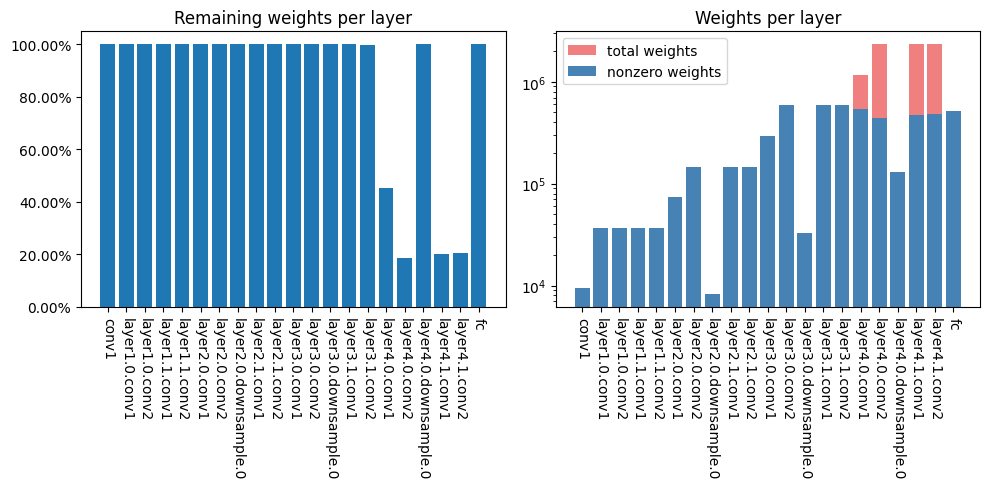

In [41]:
import numpy as np
from pquant import remove_pruning_from_model
import matplotlib.pyplot as plt
# Remove compression layers, leaves Quantized activations in place
model = remove_pruning_from_model(trained_model, config)

# Plot remaining weights
names = []
remaining = []
total_w = []
nonzeros = []
for n, m in trained_model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [42]:
def extract_conv_patterns(model):
    """
    Extracts unique binary patterns and their counts from convolutional layers
    of a given model in a backend-agnostic way.

    Args:
        model: A Keras or PyTorch model.

    Returns:
        A dictionary where keys are the names of convolutional layers and
        values are another dictionary containing:
        - 'patterns': A NumPy array of the unique binary patterns.
        - 'counts': A NumPy array with the count for each unique pattern.
        - 'kernel_shape': The original (height, width) of the kernel.
    """
    patterns_by_layer = {}
    backend = keras.backend.backend()

    # Iterate through model layers/modules
    if backend == "torch":
        modules = model.named_modules()
    else: # TensorFlow
        modules = [(layer.name, layer) for layer in model.layers]

    for name, module in modules:
        is_conv_layer = False
        if backend == "torch" and isinstance(module, (keras.layers.Conv2D, torch.nn.Conv2d)):
            weight = module.weight.detach()
            is_conv_layer = len(weight.shape) == 4
        elif backend == "tensorflow" and isinstance(module, keras.layers.Conv2D):
            weight = module.kernel
            is_conv_layer = True

        if is_conv_layer:
            all_patterns_flat = keras.ops.reshape(weight, (weight.shape[0], -1))
            all_patterns_binary = keras.ops.cast(all_patterns_flat > 0, dtype="float32")

            num_bits = all_patterns_binary.shape[1]
            if num_bits == 0:
                continue

            powers_of_2 = keras.ops.power(2.0, keras.ops.arange(num_bits, dtype="float32"))
            hashes = keras.ops.sum(all_patterns_binary * powers_of_2, axis=1)

            unique_hashes, counts = np.unique(keras.ops.convert_to_numpy(hashes), return_counts=True)
            unique_patterns_binary = ((unique_hashes[:, None] & (1 << np.arange(num_bits))) > 0).astype(float)
            
            sort_indices = np.argsort(counts)[::-1]
            patterns_by_layer[name] = {
                'patterns': unique_patterns_binary[sort_indices],
                'counts': counts[sort_indices],
                'kernel_shape': (weight.shape[2], weight.shape[3])
            }
            print(f"Processed layer '{name}', found {len(counts)} unique patterns.")

    return patterns_by_layer

In [43]:
import math

def visualize_conv_patterns(model, layer_name, max_patterns_to_show=16):
    """
    Visualizes the dominant binary patterns for a specific convolutional layer.
    """
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name and hasattr(module, "pruning_layer"):
            pruning_layer = module.pruning_layer
            if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                target_module = module
                break
    
    if target_module is None:
        print(f"Error: Could not find a PACA-pruned layer named '{layer_name}'.")
        return
        
    metric_fn = target_module.pruning_layer.metric_fn
    # Ensure dominant patterns are selected based on the final weights
    metric_fn._select_dominant_patterns(target_module.weight)
    
    patterns = metric_fn.dominant_patterns
    if patterns is None or patterns.shape[0] == 0:
        print(f"No dominant patterns found for layer '{layer_name}'.")
        return
        
    # Convert to NumPy for plotting
    patterns_np = keras.ops.convert_to_numpy(patterns)
    
    # Get original kernel shape from the weight tensor
    kernel_h, kernel_w = target_module.weight.shape[2], target_module.weight.shape[3]
    
    num_patterns = min(patterns_np.shape[0], max_patterns_to_show)
    
    # Create a subplot grid for the patterns
    cols = math.ceil(math.sqrt(num_patterns))
    rows = math.ceil(num_patterns / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    
    fig.suptitle(f"Dominant Patterns for Layer: {layer_name} (found {patterns_np.shape[0]})", fontsize=16)
    
    for i in range(num_patterns):
        pattern_2d = patterns_np[i].reshape(kernel_h, kernel_w)
        print(pattern_2d.shape)
        print(pattern_2d)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1)
        axes[i].set_title(f"Pattern {i+1}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    # Hide any unused subplots
    for j in range(num_patterns, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Add PACA prunning
#### After pruning we will have multiple patterns, so we force all of them to have a lower num,ber of dominant patterns

In [44]:
import yaml 

with open("pquant/configs/config_mdmm_paca.yaml", 'r') as f:
    config = yaml.safe_load(f)
JSON(config)

<IPython.core.display.JSON object>

In [45]:
SAVE_PATH = 'resnet_paca_pruned.pth'
torch.save(trained_model.state_dict(), SAVE_PATH)

In [46]:
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model_paca = model.to(device)
model_paca = add_compression_layers(model_paca, config, input_shape)
model_paca

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm_65, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_66, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_67, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_68, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


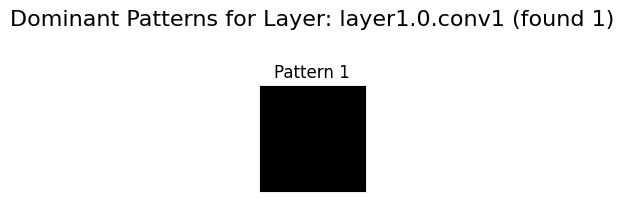

In [47]:
visualize_conv_patterns(model_paca, 'layer1.0.conv1')

In [37]:
def train_resnet(model, trainloader, device, loss_func, epoch, optimizer, scheduler, *args, **kwargs):
    first_batch = True
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.).to(device))
        loss += losses
        loss.backward()

        if first_batch:
            print("\n ---- Checking Loss values ----")
            print("Loss:", loss_func(outputs, labels).item())
            print("Model Losses:", losses.item())
            print("--------------------------------------------------")

            for name, module in model.named_modules():
                if "conv1" in name and hasattr(module, "pruning_layer"):
                    pruning_layer = module.pruning_layer
                    if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                        metric_fn = pruning_layer.metric_fn
                        num_patterns = 0
                        if metric_fn.dominant_patterns is not None:
                            num_patterns = metric_fn.dominant_patterns.shape[0]

                        total_dist = metric_fn(module.weight).item()
                        num_kernels = module.weight.shape[0]
                        avg_dist = total_dist / num_kernels if num_kernels > 0 else 0

                        print(f"--- PACA Stats for {name} at Epoch {epoch} ---")
                        print(f"Num Patterns: {num_patterns}, Avg Pattern Dist: {avg_dist:.4f}")
                        print("--------------------------------------------------\n")
                        break
            first_batch = False

        optimizer.step()
        epoch += 1
        if scheduler is not None:
            scheduler.step()

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    num_paca_patterns = 0
    avg_paca_dist = 0.0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        for name, module in model.named_modules():
            if "conv1" in name and hasattr(module, "pruning_layer"):
                pruning_layer = module.pruning_layer
                if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                    metric_fn = pruning_layer.metric_fn
                    if metric_fn.dominant_patterns is not None:
                        num_paca_patterns = metric_fn.dominant_patterns.shape[0]

                    total_dist = metric_fn(module.weight).item()
                    num_kernels = module.weight.shape[0]
                    avg_paca_dist = total_dist / num_kernels if num_kernels > 0 else 0
                    break

        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, '
              f'Remaining Weights: {ratio * 100:.2f}%, '
              f'Num Patterns: {num_paca_patterns}, '
              f'Avg Pattern Dist: {avg_paca_dist:.4f}')

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

## Create loss function, scheduler and optimizer

In [38]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [39]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model_paca = iterative_train(model = model_paca, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )


 ---- Checking Loss values ----
Loss: 0.37667882442474365
Model Losses: 0.03248338773846626
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 0 ---
Num Patterns: 16, Avg Pattern Dist: 0.2495
--------------------------------------------------

Accuracy: 86.72%, Remaining Weights: 20.65%, Num Patterns: 1, Avg Pattern Dist: 0.0000

 ---- Checking Loss values ----
Loss: 0.4868629276752472
Model Losses: 0.0021182468626648188
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 197 ---
Num Patterns: 1, Avg Pattern Dist: 0.0000
--------------------------------------------------

Accuracy: 79.86%, Remaining Weights: 22.02%, Num Patterns: 1, Avg Pattern Dist: 0.0000

 ---- Checking Loss values ----
Loss: 0.6703610420227051
Model Losses: 0.001172768184915185
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 394 ---
Num Patterns: 1, Avg Pattern Dist: 0.0000
--------------------------------------

KeyboardInterrupt: 

(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


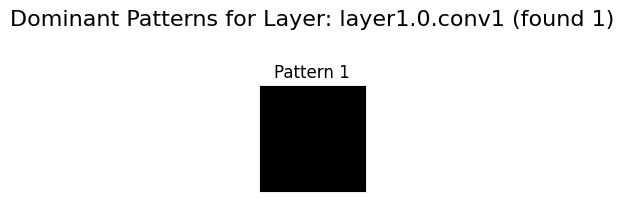

In [40]:
visualize_conv_patterns(model_paca, 'layer1.0.conv1')